In [152]:
# !pip install netcal

In [435]:
import pandas as pd

In [458]:
path_csv = "/Users/tuananh/tuananh/domain_calibration/experiments/Office/amazon/resnet_34_kfold_val_logits_amazon.csv"
df = pd.read_csv(path_csv)
# df['logit'] = df['logit'].apply(lambda x: ast.literal_eval(x))
df

,Unnamed: 0,imageid,classes,kfold,logit,predict,phase
0,282,laptop_computer__frame_0080.jpg,12,0,"[-10.294256, -9.007425, -9.512556, -6.807109, ...",12,val
1,428,phone__frame_0001.jpg,20,0,"[-5.276699, -7.257102, -9.715171, -9.2730875, ...",20,val
2,197,monitor__frame_0003.jpg,15,0,"[-10.3331585, -8.529431, -11.670894, -2.036896...",15,val
3,590,phone__frame_0064.jpg,20,0,"[-10.03364, -9.453067, -11.440785, -11.168621,...",20,val
4,818,mug__frame_0027.jpg,17,0,"[-5.1701794, -9.596927, -2.6951683, -9.289126,...",17,val
...,...,...,...,...,...,...,...
2812,2150,mobile_phone__frame_0030.jpg,14,2,"[-8.449489, -11.234646, -14.445171, -7.920084,...",14,val
2813,2528,desk_lamp__frame_0008.jpg,7,2,"[-7.906639, -11.056042, -14.101571, -8.412042,...",7,val
2814,1999,printer__frame_0048.jpg,21,2,"[-5.6841564, -12.291994, -12.139945, -8.058773...",21,val
2815,2407,ring_binder__frame_0081.jpg,24,2,"[-10.035503, -12.544436, -18.740713, -5.716702...",24,val


In [465]:
validation = 1

condition = df.kfold == validation

train_logits = np.vstack([json.loads(x) for x in df[~condition]['logit'].values])
train_ground_truth = df[~condition]["classes"].values
train_confidences = torch.softmax(torch.from_numpy(train_logits), 1).numpy()

val_logits = np.vstack([json.loads(x) for x in df[condition]['logit'].values])
val_ground_truth = df[condition]["classes"].values
val_confidences = torch.softmax(torch.from_numpy(val_logits), 1).numpy()

In [466]:
import numpy as np
from netcal.scaling import TemperatureScaling

temperature = TemperatureScaling(vi_epochs=2000)
temperature.fit(train_confidences, train_ground_truth)
val_calibrated = temperature.transform(val_confidences)

In [467]:
from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(val_confidences, val_ground_truth)
calibrated_score = ece.measure(val_calibrated, val_ground_truth)

print(uncalibrated_score, calibrated_score)

0.0334051642320759 0.07177258232911937


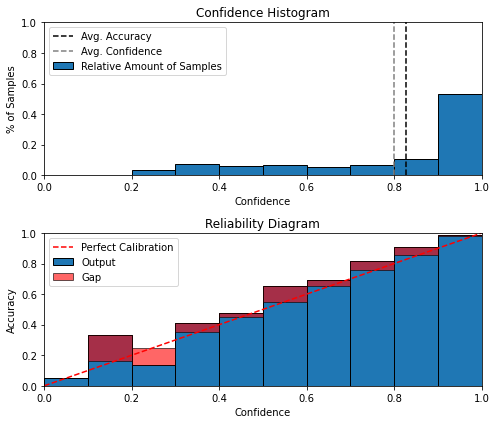

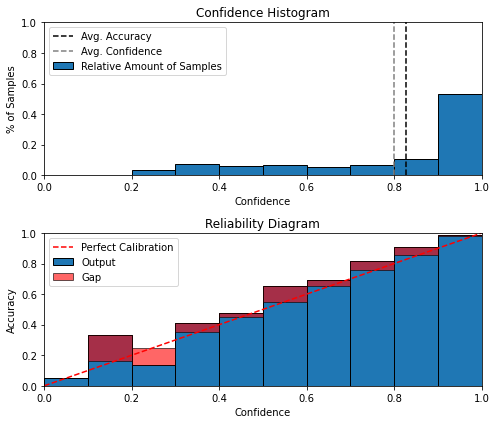

In [468]:
from netcal.presentation import ReliabilityDiagram

n_bins = 10

diagram = ReliabilityDiagram(n_bins)
diagram.plot(val_confidences, val_ground_truth)

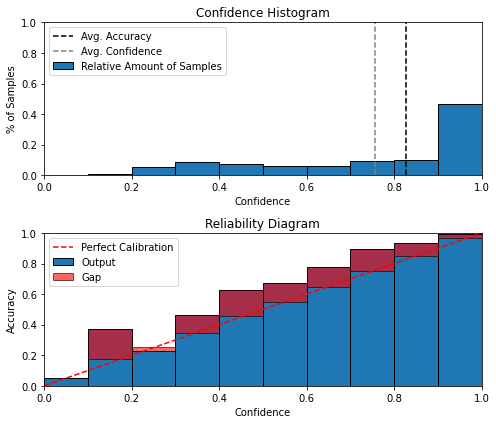

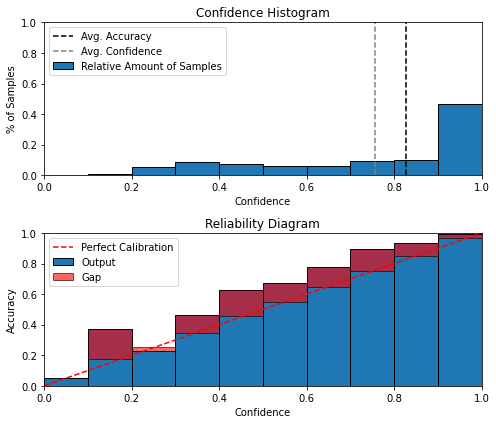

In [469]:
from netcal.presentation import ReliabilityDiagram

n_bins = 10

diagram = ReliabilityDiagram(n_bins)
diagram.plot(val_calibrated, val_ground_truth)

# Other Method

In [443]:
path_csv = "/Users/tuananh/tuananh/domain_calibration/experiments/Office/amazon/resnet_34_kfold_val_logits_amazon.csv"
df = pd.read_csv(path_csv)

validation = 1

condition = df.kfold == validation

train_logits = np.vstack([json.loads(x) for x in df[~condition]['logit'].values])
train_ground_truth = df[~condition]["classes"].values
train_confidences = torch.softmax(torch.from_numpy(train_logits), 1).numpy()

val_logits = np.vstack([json.loads(x) for x in df[condition]['logit'].values])
val_ground_truth = df[condition]["classes"].values
val_confidences = torch.softmax(torch.from_numpy(val_logits), 1).numpy()

In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F


class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self


class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).

    The input to this loss is the logits of a model, NOT the softmax scores.

    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:

    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |

    We then return a weighted average of the gaps, based on the number
    of samples in each bin

    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece